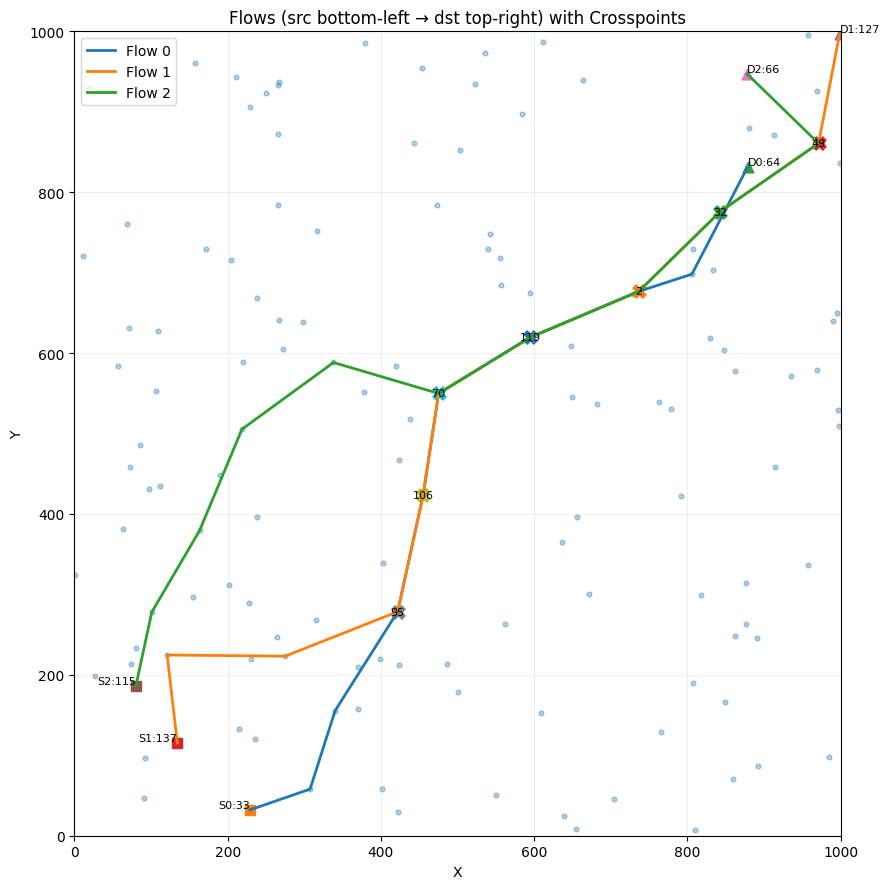


=== Flow Summary ===
 Flow ID  Source  Destination  Hops                               Path                                                                                       Crosspoints  CrosspointCount
       0      33           64     9     33→65→11→95→106→70→119→2→10→64                             95@(421,278); 106@(455,423); 70@(475,549); 119@(594,619); 2@(736,676)                5
       1     137          127    10 137→77→1→95→106→70→119→2→32→49→127 95@(421,278); 106@(455,423); 70@(475,549); 119@(594,619); 2@(736,676); 32@(842,775); 49@(971,860)                7
       2     115           66    10   115→23→29→5→78→70→119→2→32→49→66                              70@(475,549); 119@(594,619); 2@(736,676); 32@(842,775); 49@(971,860)                5

=== Crosspoint Summary (nodes used by >=2 flows) ===
 Node   X   Y UsedByFlows  FlowDegree
    2 736 676       0,1,2           3
   70 475 549       0,1,2           3
  119 594 619       0,1,2           3
   32 842 775         1,2   

In [1]:
import math
import random
from collections import defaultdict
from itertools import combinations

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

# ----------------------------
# Configurable parameters
# ----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

AREA_WIDTH = 1000
AREA_HEIGHT = 1000
NUM_NODES = 140
COMM_RADIUS = 160

# Flow selection controls
NUM_SOURCES = 3   # you can change this
NUM_DESTS = 3     # you can change this

# Regions for picking sources and destinations
SRC_REGION_FRACTION = 0.28   # bottom-left box size (fraction of width/height)
DST_REGION_FRACTION = 0.28   # top-right box size
MIN_SEPARATION = 60          # minimum Euclidean distance between chosen sources (and between destinations)

#Graph options
LEGEND_MAX_FLOWS = 12        # show legend only if number of flows <= this

# ----------------------------
# Core classes
# ----------------------------

class Node:
    def __init__(self, nid: int, x: float, y: float):
        self.id = nid
        self.x = x
        self.y = y

    @property
    def pos(self):
        return (self.x, self.y)


class Flow:
    def __init__(self, fid: int, src: int, dst: int, path: list[int]):
        self.id = fid
        self.src = src
        self.dst = dst
        self.path = path  # list of node IDs along the route


class Network:
    def __init__(self, n_nodes: int, width: int, height: int, comm_radius: float):
        self.n = n_nodes
        self.width = width
        self.height = height
        self.comm_radius = comm_radius
        self.nodes: dict[int, Node] = {}
        self.G = nx.Graph()
        self.flows: list[Flow] = []
        self.crosspoint_flows: dict[int, set[int]] = defaultdict(set)  # node_id -> set(flow_ids)

    # ---- Topology ----
    def generate_nodes_uniform(self):
        """Place nodes uniformly at random in the area."""
        for i in range(self.n):
            x = random.uniform(0, self.width)
            y = random.uniform(0, self.height)
            node = Node(i, x, y)
            self.nodes[i] = node
            self.G.add_node(i, pos=node.pos)

    def _dist(self, i: int, j: int) -> float:
        pi = np.array(self.nodes[i].pos)
        pj = np.array(self.nodes[j].pos)
        return float(np.linalg.norm(pi - pj))

    def build_links_by_radius(self):
        """Create undirected edges between nodes within COMM_RADIUS."""
        ids = list(self.nodes.keys())
        for a in range(len(ids)):
            i = ids[a]
            for b in range(a + 1, len(ids)):
                j = ids[b]
                if self._dist(i, j) <= self.comm_radius:
                    self.G.add_edge(i, j)

    # ---- Flow selection ----
    def _pick_from_region(self, region: str, k: int, min_sep: float) -> list[int]:
        """Pick k distinct node IDs from a geometric region with minimum separation."""
        candidates = []
        if region == "src":
            # bottom-left rectangle
            for nid, node in self.nodes.items():
                if node.x <= self.width * SRC_REGION_FRACTION and node.y <= self.height * SRC_REGION_FRACTION:
                    candidates.append(nid)
        elif region == "dst":
            # top-right rectangle
            for nid, node in self.nodes.items():
                if node.x >= self.width * (1 - DST_REGION_FRACTION) and node.y >= self.height * (1 - DST_REGION_FRACTION):
                    candidates.append(nid)
        else:
            candidates = list(self.nodes.keys())

        chosen: list[int] = []
        tries = 0
        while len(chosen) < k and tries < 10000 and candidates:
            nid = random.choice(candidates)
            # check separation
            ok = True
            for cid in chosen:
                if self._dist(nid, cid) < min_sep:
                    ok = False
                    break
            if ok:
                chosen.append(nid)
                candidates.remove(nid)
            else:
                tries += 1
                candidates.remove(nid)
        return chosen

    def add_flows_bottomleft_to_topright(self, n_src: int, n_dst: int):
        """Create flows by pairing sources (bottom-left) with destinations (top-right)."""
        sources = self._pick_from_region("src", n_src, MIN_SEPARATION)
        dests = self._pick_from_region("dst", n_dst, MIN_SEPARATION)

        n_flows = min(len(sources), len(dests))
        if n_flows == 0:
            return

        # random pairing
        random.shuffle(sources)
        random.shuffle(dests)

        fid = 0
        for i in range(n_flows):
            s = sources[i]
            d = dests[i]
            # find a path; if none, try alternative pairings by small permutations
            path = None
            attempts = 0
            while path is None and attempts < 12:
                try:
                    path = nx.shortest_path(self.G, s, d)
                except nx.NetworkXNoPath:
                    # try swapping destination within list if possible
                    j = (i + attempts) % n_flows
                    d = dests[j]
                    attempts += 1
            if path is not None:
                self.flows.append(Flow(fid, s, d, path))
                fid += 1

    # ---- Analysis ----
    def compute_crosspoints(self):
        """Populate crosspoint_flows: nodes that belong to TWO or more flow paths."""
        self.crosspoint_flows.clear()
        for fl in self.flows:
            for nid in fl.path:
                self.crosspoint_flows[nid].add(fl.id)
        # keep only nodes used by >=2 flows
        self.crosspoint_flows = {nid: s for nid, s in self.crosspoint_flows.items() if len(s) >= 2}

    # ---- Visualization ----
    def visualize(self, show_edges: bool = False, show_legend: bool = True, title: str = "Flows and Crosspoints"):
        """Draw nodes, flows, sources/dests, and crosspoints. Axis with (0,0) to (W,H)."""
        plt.figure(figsize=(9, 9))

        # Draw nodes (faint)
        xs = [n.x for n in self.nodes.values()]
        ys = [n.y for n in self.nodes.values()]
        plt.scatter(xs, ys, s=12, alpha=0.35)

        # Optionally draw all graph edges (faint, to show connectivity)
        if show_edges:
            for (u, v) in self.G.edges():
                x0, y0 = self.nodes[u].pos
                x1, y1 = self.nodes[v].pos
                plt.plot([x0, x1], [y0, y1], linewidth=0.3, alpha=0.2)

        # Plot each flow's path; matplotlib will cycle colors automatically
        for fl in self.flows:
            path_coords = [self.nodes[nid].pos for nid in fl.path]
            xs, ys = zip(*path_coords)
            plt.plot(xs, ys, linewidth=2, label=f"Flow {fl.id}")

            # mark source and destination
            sx, sy = self.nodes[fl.src].pos
            dx, dy = self.nodes[fl.dst].pos
            plt.scatter([sx], [sy], s=60, marker="s")  # source
            plt.scatter([dx], [dy], s=60, marker="^")  # destination
            # annotate IDs
            plt.text(sx, sy, f"S{fl.id}:{fl.src}", fontsize=8, ha="right", va="bottom")
            plt.text(dx, dy, f"D{fl.id}:{fl.dst}", fontsize=8, ha="left", va="bottom")

        # Mark crosspoints with larger markers and annotate node IDs
        for nid, flowset in self.crosspoint_flows.items():
            x, y = self.nodes[nid].pos
            plt.scatter([x], [y], s=90, marker="X")
            plt.text(x, y, f"{nid}", fontsize=8, ha="center", va="center")

        # Axes and limits
        plt.xlim(0, self.width)
        plt.ylim(0, self.height)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title(title)

        # Only show legend if not too many flows
        if show_legend and len(self.flows) <= LEGEND_MAX_FLOWS:
            plt.legend(loc="best")

        plt.grid(True, alpha=0.2)
        plt.tight_layout()
        plt.show()

    # ---- Tables ----
    def flows_table(self) -> pd.DataFrame:
        rows = []
        for fl in self.flows:
            hop_count = len(fl.path) - 1
            shared = [nid for nid in fl.path if nid in self.crosspoint_flows]
            shared_str = "; ".join([f"{nid}@({int(self.nodes[nid].x)},{int(self.nodes[nid].y)})" for nid in shared])
            path_str = "→".join(map(str, fl.path))
            rows.append({
                "Flow ID": fl.id,
                "Source": fl.src,
                "Destination": fl.dst,
                "Hops": hop_count,
                "Path": path_str,
                "Crosspoints": shared_str,
                "CrosspointCount": len(shared)
            })
        return pd.DataFrame(rows)

    def crosspoints_table(self) -> pd.DataFrame:
        rows = []
        for nid, flowset in sorted(self.crosspoint_flows.items(), key=lambda kv: (-len(kv[1]), kv[0])):
            x, y = self.nodes[nid].pos
            flows_str = ",".join(map(str, sorted(list(flowset))))
            rows.append({
                "Node": nid,
                "X": int(x),
                "Y": int(y),
                "UsedByFlows": flows_str,
                "FlowDegree": len(flowset)
            })
        return pd.DataFrame(rows)


# ----------------------------
# Run one simulation
# ----------------------------
net = Network(NUM_NODES, AREA_WIDTH, AREA_HEIGHT, COMM_RADIUS)
net.generate_nodes_uniform()
net.build_links_by_radius()
net.add_flows_bottomleft_to_topright(NUM_SOURCES, NUM_DESTS)
net.compute_crosspoints()
net.visualize(show_edges=False, show_legend=True, title="Flows (src bottom-left → dst top-right) with Crosspoints")

# Print tables directly
flows_df = net.flows_table()
cross_df = net.crosspoints_table()

print("\n=== Flow Summary ===")
print(flows_df.to_string(index=False))

print("\n=== Crosspoint Summary (nodes used by >=2 flows) ===")
if len(cross_df) == 0:
    print("No crosspoints in this run.")
else:
    print(cross_df.to_string(index=False))
